This simulates the Viscek model for the creation of traffic jams.  Cars are defined by their position (x), as well as their velocity (vx); the cars all travel on the straight line.

For an arbitrary state, one update of the system consists of the following four steps, performed in parallel for all vehicles:

The birds move according to the following rules:
1. Acceleration: if the velocity $v$ of a vehicle is lower than $v_{\max}$ and if the distance to the car ahead is larger than $v + 1$, increase the speed by one $[v\to v +1]$.
2.  Deceleration: if a vehicle at site $i$ sees the next vehicle at site $i + j$ with $j\leq v$, it reduces its speed to $j-1[v\rightarrow j-1]$.
3. Randomisation: with probability $p$, the vehicles velocity is decreased by one to a minimum of zero $[v\to \max(v-1,0)]$.
4. Each vehicle is advanced v sites.
5. Initialisation: if a vehicle reaches site $R$, the end of the road, it is removed from the grid. To replace it, a new vehicle is initialised with a random velocity between $1$ and the speed of the first vehicle on the road. This is to ensure that it doesn't crash or overtake a car when it joins the stretch of road that we are examining and a car cannot join a road with velocity 0. The vehicle is placed on the road at a random site between $0$ and its velocity as that is the maximum distance it will be travel in one time step.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import matplotlib.animation as animation
from IPython.display import HTML

# Simulation parameters
L = 50          # Length of the road
num_cars = 10   # Number of cars
vmax = 5        # Maximum speed
p = 0.15         # Probability of random deceleration

def initialize_cars(N, L):
    '''
    Initialize car positions, velocities, and colours.
    '''
    car_positions = np.sort(np.random.choice(range(L), N, replace=False))  # Ensure unique positions
    car_velocities = np.random.randint(1, vmax + 1, size=N)  # Random initial velocities between 1 and vmax
    car_colours = plt.cm.rainbow(np.linspace(0, 1, N))

    return car_positions, car_velocities, car_colours

def next_distance(car_positions, pos, L):
    '''
    Finds the distance to the next car.
    '''
    next_car_pos = car_positions[(pos + 1) % len(car_positions)]
    distance = (next_car_pos - car_positions[pos] - 1) % L
    
    return distance

def update_velocity(car_positions, car_velocities, vmax, p):
    '''
    Update velocities of cars based on traffic rules.
    '''
    N = len(car_positions)

    # Step 1: Acceleration
    for i in range(N):
        if car_velocities[i] < vmax:
            distance_to_next = next_distance(car_positions, i, L)
            if distance_to_next > car_velocities[i]:
                car_velocities[i] += 1

    # Step 2: Deceleration
    for i in range(N):
        distance_to_next = next_distance(car_positions, i, L)
        if car_velocities[i] >= distance_to_next:
            car_velocities[i] = distance_to_next

    # Step 3: Randomisation
    for i in range(N):
        if np.random.rand() < p:
            car_velocities[i] = max(car_velocities[i] - 1, 0)

    return car_velocities

def apply_boundary_conditions(car_positions, car_velocities, L):
    '''
    Remove cars that reach the end of the road and replace them with new cars at position 0.
    '''
    for i in range(len(car_positions)):
        if car_positions[i] >= L:  # Check if car is beyond the boundary
            # Find the car in front to set a speed limit for the new car
            front_car_velocity = car_velocities[(i + 1) % len(car_velocities)]
            distance_to_next = next_distance(car_positions, i, L)
            new_velocity = np.random.randint(1, front_car_velocity + 1) if front_car_velocity > 0 else 1
            new_position = np.random.randint(0, min(distance_to_next, new_velocity)) if distance_to_next > 0 else 0

            # Replace the car with the new position and velocity
            car_positions[i] = new_position
            car_velocities[i] = new_velocity

    return car_positions, car_velocities

def update_positions(car_positions, car_velocities, L):
    '''
    Update car positions based on their velocities and apply boundary conditions.
    '''
    car_positions = (car_positions + car_velocities)  # Update positions
    car_positions, car_velocities = apply_boundary_conditions(car_positions, car_velocities, L)
    
    return car_positions, car_velocities  # Sort to maintain order after movement

def step(car_positions, car_velocities, L, vmax, p):
    '''
    Perform a single time step update: update velocities and positions.
    '''
    car_velocities = update_velocity(car_positions, car_velocities, vmax, p)
    car_positions, car_velocities = update_positions(car_positions, car_velocities, L)
    
    return car_positions, car_velocities

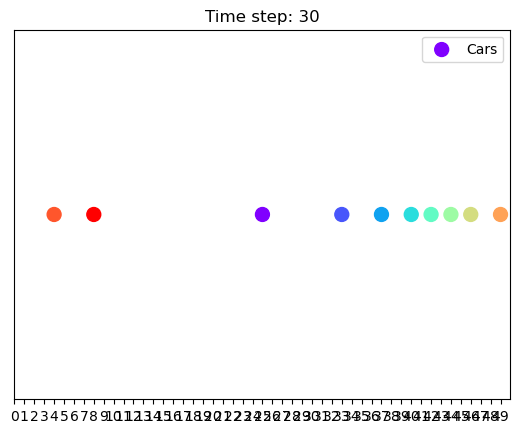

In [11]:
# Initialize cars
car_positions, car_velocities, car_colours = initialize_cars(num_cars, L)

# Set up the figure for animation
fig, ax = plt.subplots()
ax.set_xlim(0, L)
ax.set_ylim(-1, 1)
ax.set_xticks(range(L))
ax.set_yticks([])

# Initial scatter plot for cars with different colours
scat = ax.scatter(car_positions, np.zeros(num_cars), c=car_colours, s=100, label='Cars')
plt.legend()

# Function to update the plot at each time step
def animate(i_step):
    global car_positions, car_velocities
    car_positions, car_velocities = step(car_positions, car_velocities, L, vmax, p)
    scat.set_offsets(np.c_[car_positions, np.zeros(num_cars)])
    ax.set_title(f"Time step: {i_step}")

# Number of steps to animate - Change this if you want for a longer timeframe
n_steps = 31

# Run the animation
for i_step in range(n_steps):
    animate(i_step)
    plt.pause(0.1)
    clear_output(wait=True)
    display(fig)

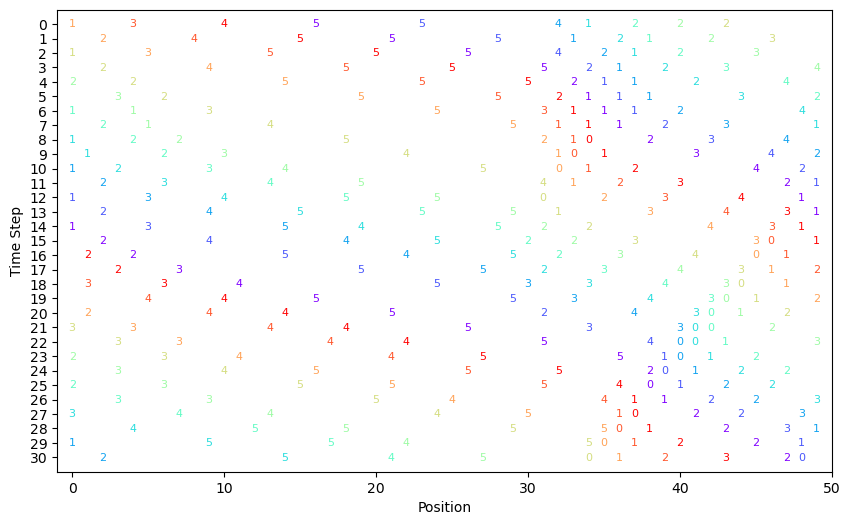

In [8]:
# Set up the figure for velocity-time plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-1, L)
ax.set_ylim(n_steps, -1)
ax.set_yticks(np.arange(0, n_steps, 1))
ax.set_xlabel('Position')
ax.set_ylabel('Time Step')

# Run the simulation for the specified number of time steps
for i_step in range(n_steps):
    # Plot the velocity of each car at its position for the current time step
    for i in range(num_cars):
        ax.text(car_positions[i], i_step, car_velocities[i], ha='center', va='center', fontsize=8, color=car_colours[i])
        #ax.plot(car_positions[i], i_step, car_velocities[i], kind = 'line', marker = 'o')
    
    # Update the state of the system
    car_positions, car_velocities = step(car_positions, car_velocities, L, vmax, p)

plt.show()